# Wczytywanie danych medycznych
Opracowanie: A.Florkowska

In [1]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.ndimage
import matplotlib.pyplot as plt
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from IPython.display import Image

# Co to jest DICOM?
DICOM to standardowy format używany do zapisywania, przechowywania, czy przesyłania medycznych danych obrazowych, takich jak MRI czy CT. 

Standard DICOM definiuje sposób kodowania danych obrazowych i metadanych (informacje o pacjencie protkoły badania, informacje o urządzeniu etc). Zapewnia to na zachowanie spójności zapisu, przy jednoczesnym użytkowaniu sprzętu od różnych dostawców.

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 244
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Computed Radiography Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.8.498.65452424240994805812717428674475343109
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.2.1143.107.104.103.115.3.0.10
(0002, 0013) Implementation Version Name         SH: 'GDCM 3.0.10'
(0002, 0016) Source Application Entity Title     AE: 'gdcmconv'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY']
(0008, 0012) Instance Creation Date              DA: ''
(0008, 0013) Instance Creation Time              TM: ''
(0008, 0016) SOP Class UID                       UI:

C:\Users\agnie\anaconda3\envs\imaging\Lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (15-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Text(0.5, 1.0, 'XRAY')

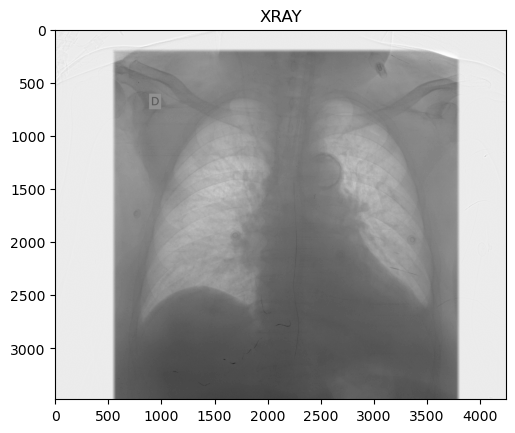

In [2]:
imageXRAY = pydicom.read_file(".././images/example2.dcm")
print(imageXRAY)

plt.imshow(imageXRAY.pixel_array, cmap='gray')
plt.title("XRAY")

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.9823.1001.221177562744898672748755692263
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.27'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'SECONDARY', 'M_SE', 'M', 'SE']
(0008, 0013) Instance Creation Time              TM: '161804'
(0008, 0014) Instance Creator UID                UI: 1.3.6.1.4.1.14519.5.2.1.9823.1001.156395802095726831961634081923
(0008, 0016) SOP Class UID  

Text(0.5, 1.0, 'MRI')

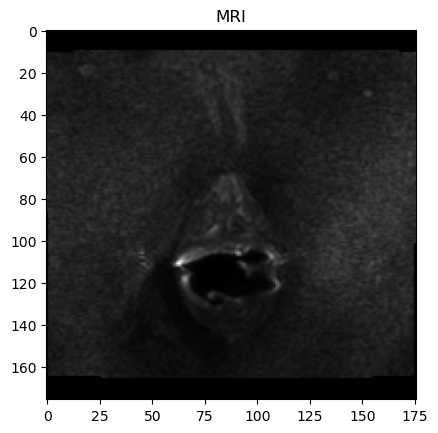

In [3]:
imageMRI = pydicom.read_file(".././images/example3.dcm")
print(imageMRI)

plt.imshow(imageMRI.pixel_array, cmap='gray')
plt.title("MRI")

# Skala Hounsfielda

Podczas pracy z danymi z tomografii komputerowej (CT) kluczowe znaczenie ma odpowiednie zrozumienie tego co one prezentują. Tomografia komputerowa to metoda diagnostyczna wykorzystujące promieniowanie rentgenowskie w celu uzyskania wielowarstkowych, przekrojowych obrazów ciała. Z kolei, promieniowanie rentgenowskie (inaczej X) to rodzaj promieniowania elektromagnetycznego, które jest generowane podczas wyhamowywania elektronów.

Promieniowanie rentgenowskie przechodzi przez ciało pacjenta, a różne tkanki absorbują różne ilości promieniowania, co pozwala na uzyskanie obrazów strukturalnych, takich jak kości i tkanki miękkie. W efekcie, dane z CT przedstawiają gęstość radiologiczną, wyrażona w jednostkach skali Hounsfielda (HU). Skala jednostek Hounsfielda jest liniowym przekształceniem pierwotnego pomiaru liniowego współczynnika osłabienia, w której gęstość radiologiczna wody destylowanej w standardowej temperaturze i ciśnieniu (warunki standardowe) jest definiowana jako 0 HU, natomiast gęstość powietrza w warunkach standardowych jest określana jako -1000 HU.

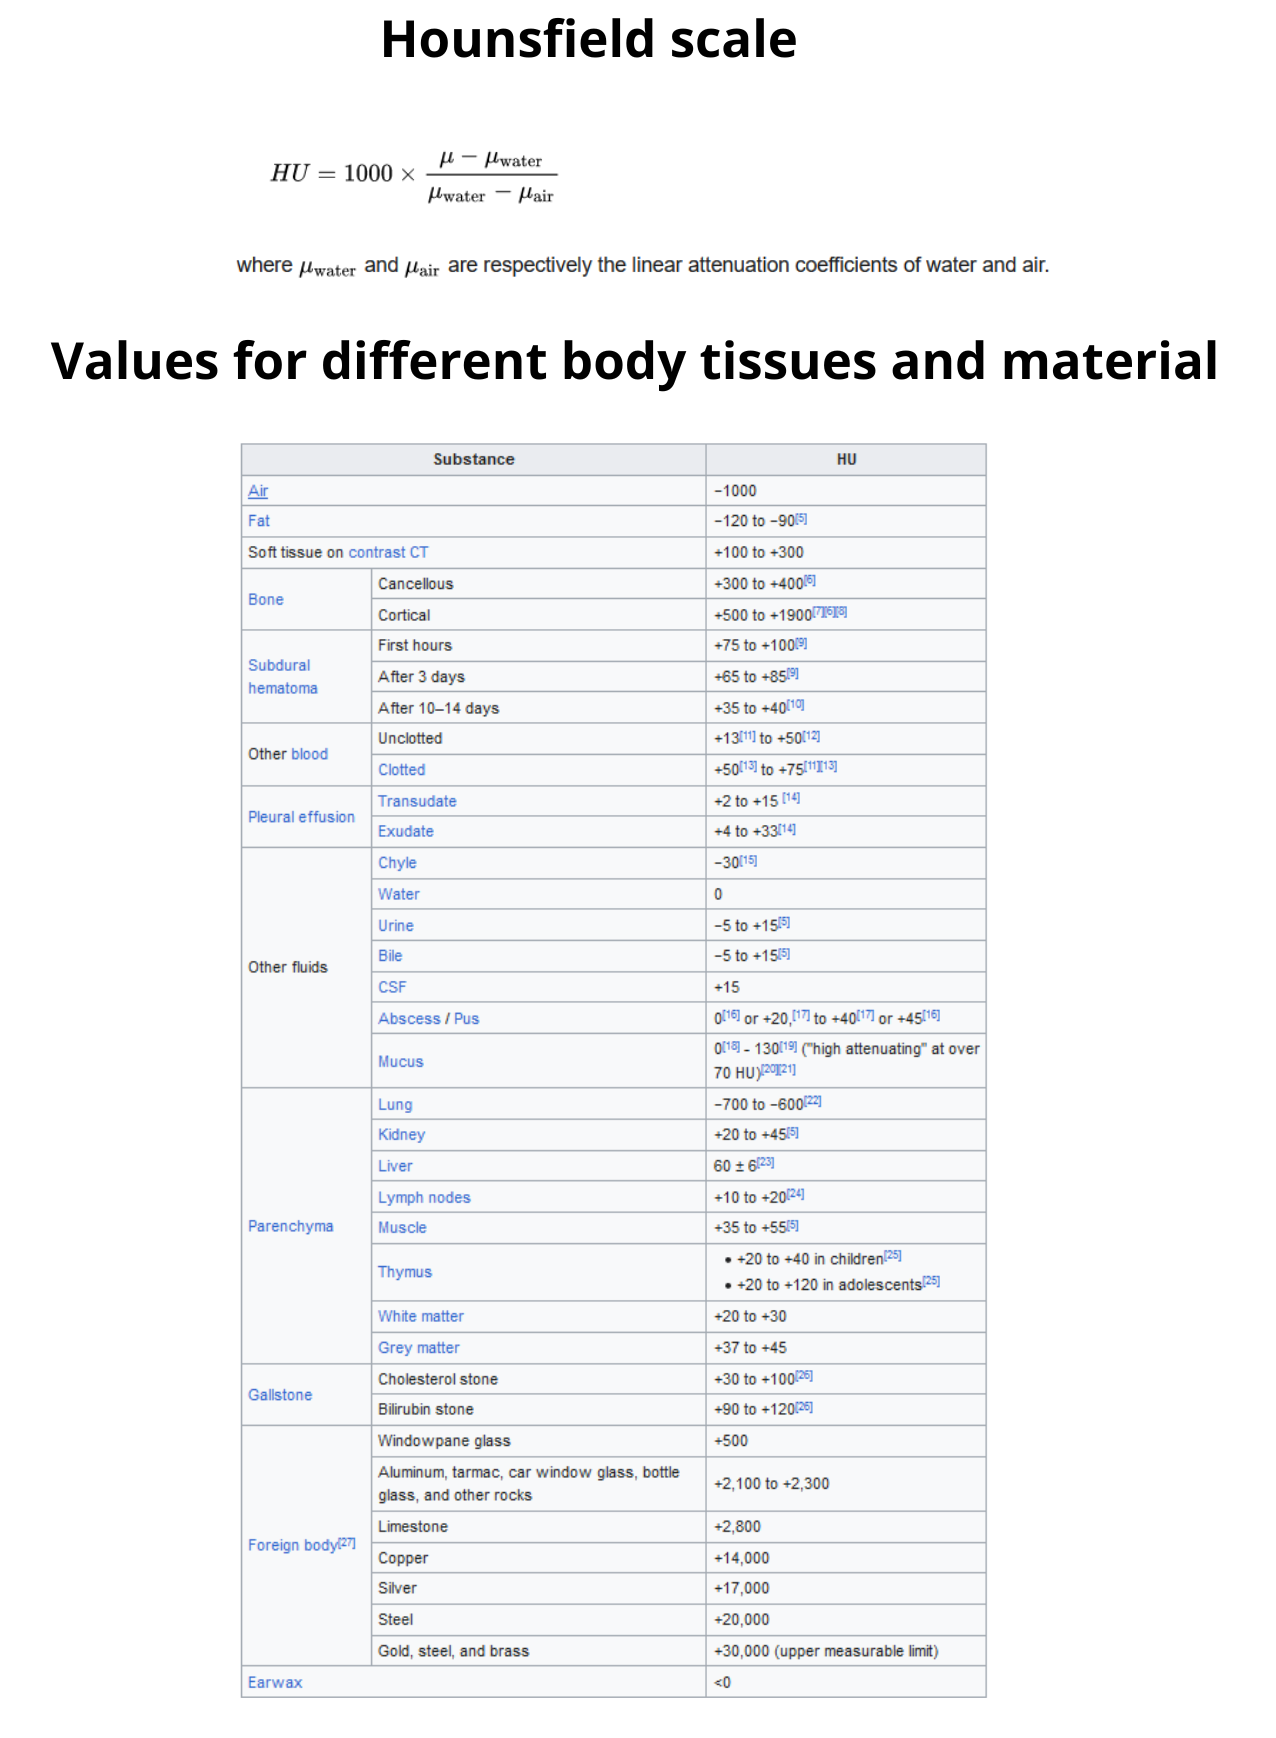

In [4]:
Image(filename=".././images/9_1.png", width=600)
# Source: https://en.wikipedia.org/wiki/Hounsfield_scale

# Resampling - ponowne próbkowanie

Dane zapisane w formacie DICOM zawierają wiele metadanych m.in. informacje o grubości piksela (slice thickness) oraz odległości między kolejnymi pikselami (pixel spacing). W praktyce może się zdarzyć, że wartości tych tagów są zależne od skanów, co może negatywnie wpłynać na wydajność np. podczas analizy przy użyciu konwolucyjnych sieci neuronowych. Na szczęście można temu zaradzić, poprzez ponownie próbkowanie, zazwyczaj do rozmiarów 1 mm x 1mm x 1mm.

In [9]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()


# Normalizacja

# Centralizacja do 0

# Źródła
- Pełny tutorial: https://www.kaggle.com/code/joncarlisle/full-preprocessing-tutorial